In [56]:
#libraries 
import numpy as np
import pandas as pd
import re

#preprocessing
import string

#translation 
from nltk.translate.bleu_score import sentence_bleu

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#visualization 
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\hirom\OneDrive - NOVAIMS\NOVA IMS\OneDrive_1_25-02-2021\Text Mining\Project\corpus\de-en\scores.csv")
df.head(4)

,source,reference,translation,z-score,avg-score,annotators
0,"Ihr Zeitlupentempo maßen sie, als sie vor Spit...",Her timeless pace measures them when they equi...,Their slow speed was measured by researchers o...,-0.345024,76.0,1
1,"Er sagte, dass die Bereiche ruhige Treffpunkte...",He said the areas offer quiet meeting points b...,He said the spaces provided calm meeting point...,0.903800,97.5,2
2,Für die Geschäftsleute an der B 27 ist es nur ...,"For businessmen at the B 27, it's only a small...",This is only a small consolation for businesse...,0.700503,94.0,1
3,Diese Fähigkeit sei möglicherweise angeboren o...,This ability may be born or developed with gen...,"This ability may be innate, or may develop as ...",-1.256572,51.5,2


In [3]:
df.shape

(21704, 6)

In [4]:
df.describe()

,z-score,avg-score,annotators
count,21704.000000,21704.000000,21704.000000
mean,0.000898,71.852890,1.502995
std,0.855140,26.348469,0.810923
min,-5.806322,0.000000,1.000000
25%,-0.499574,56.000000,1.000000
50%,0.216756,79.000000,1.000000
75%,0.640273,94.000000,2.000000
max,2.535434,100.000000,9.000000


In [21]:
pd.pivot_table(df, values = 'z-score', index =['translation'], aggfunc = 'count')

,z-score
translation,
"""A Generation Is Protesting"" in Ethiopia, Long a U.S. Ally",7
"""A Square Meal"" is a feast of historical tidbits.",4
"""A cultural change, a mental change, a physical change,"" Bam said.",4
"""A lot of former customers got priced out of Williamsburg too,"" he said.",5
"""A lot of the stuff I get is late 60s, early 70s, things that came out when I was 11 or 12, things I was probably a bit too young to get,"" he says.",10
...,...
"You're not singing by yourself - and in a group of 50 people singing, who'll hear if a note's out here or there?",9
YouTube Gaming is owned by Google's parent company Alphabet.,9
Young people are particularly vulnerable to this.,5


<AxesSubplot:xlabel='avg-score', ylabel='annotators'>

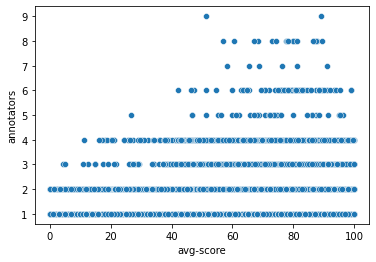

In [7]:
sns.scatterplot(x=df['avg-score'], y=df['annotators'], palette="ch:r=-.2,d=.3_r")

<AxesSubplot:xlabel='z-score', ylabel='annotators'>

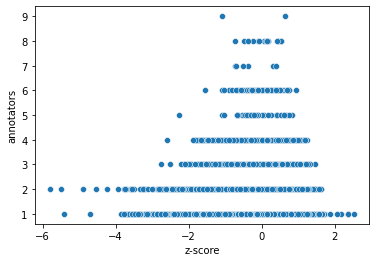

In [8]:
# The z score tells you how many standard deviations from the mean your score is.
sns.scatterplot(x=df['z-score'], y=df['annotators'], palette="ch:r=-.2,d=.3_r")

In [97]:
reference =df['reference']
translation = df['translation']

## Preprocessing 

In [24]:
df.isnull().sum()

source         0
reference      0
translation    0
z-score        0
avg-score      0
annotators     0
dtype: int64

In [136]:
def preprocessing(column):
    pp_column = []
    for sentence in column:
        #exclude punctuation 
        sentence = re.sub(r'[^A-Za-z0-9]',' ',sentence)
        #transform everything in lowercase
        sentence = sentence.lower()
        pp_column.append(sentence)
        
    processed = pd.Series(pp_column)
    return processed

In [137]:
p_reference = preprocessing(reference)
p_translation = preprocessing(translation)

In [145]:
df_cp = df.copy()

In [146]:
df_cp = pd.concat([df_cp,p_reference.rename('p_reference')], axis=1)

In [147]:
df_cp = pd.concat([df_cp,p_translation.rename('p_translation')], axis=1)

In [150]:
df_cp.head(4)

,source,reference,translation,z-score,avg-score,annotators,p_reference,p_translation
0,"Ihr Zeitlupentempo maßen sie, als sie vor Spit...",Her timeless pace measures them when they equi...,Their slow speed was measured by researchers o...,-0.345024,76.0,1,her timeless pace measures them when they equi...,their slow speed was measured by researchers o...
1,"Er sagte, dass die Bereiche ruhige Treffpunkte...",He said the areas offer quiet meeting points b...,He said the spaces provided calm meeting point...,0.903800,97.5,2,he said the areas offer quiet meeting points b...,he said the spaces provided calm meeting point...
2,Für die Geschäftsleute an der B 27 ist es nur ...,"For businessmen at the B 27, it's only a small...",This is only a small consolation for businesse...,0.700503,94.0,1,for businessmen at the b 27 it s only a small...,this is only a small consolation for businesse...
3,Diese Fähigkeit sei möglicherweise angeboren o...,This ability may be born or developed with gen...,"This ability may be innate, or may develop as ...",-1.256572,51.5,2,this ability may be born or developed with gen...,this ability may be innate or may develop as ...


In [154]:
df_cp.groupby('p_translation')['p_reference'].apply(list)

p_translation
 a cultural change  a mental change  a physical change   bam said                                                                                      [ a cultural change  a mental change and a phy...
 a generation is protesting  in ethiopia  long a u s  ally                                                                                             [ a generation protest in ethiopia  long an al...
 a lot of former customers got priced out of williamsburg too   he said                                                                                [ many old customers were also ousted by price...
 a lot of the stuff i get is late 60s  early 70s  things that came out when i was 11 or 12  things i was probably a bit too young to get   he says     [ many things  which i buy  are from the late ...
 a square meal  is a feast of historical tidbits                                                                                                       [ a square meal  is a festival 

## BLEU Score

#bleu score - quantidade de palavras iguais na referencia e na tradução. 
https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
https://towardsdatascience.com/nlp-metrics-made-simple-the-bleu-score-b06b14fbdbc1


#Word2vec 
https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial
https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

#WMD METHOD - highly recommende to text similarity and text summarizations 
https://towardsdatascience.com/word-movers-distance-for-text-similarity-7492aeca71b0

#ROUGE - evaluation for reference and translation

EVALUATIONS METHODS 
https://iconictranslation.com/2020/11/issue-109-comet-the-crosslingual-optimised-metric-for-evaluation-of-translation/
https://ai.googleblog.com/2020/05/evaluating-natural-language-generation.html#:~:text=BLEURT%20is%20a%20novel,%20machine,ratings%20provided%20by%20the%20user.
https://arxiv.org/pdf/1904.09675.pdf